In [1]:
import pandas as pd

## 6.1 パイプラインによるワークフローの効率化

In [15]:
# 書籍のURLは404 not foundになるので以下を使う
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
le.transform(['M', 'B'])

array([1, 0])

In [8]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [20]:
pipe_lr = Pipeline([('scl', StandardScaler()), ('pca', PCA(n_components=2)), ('clf', LogisticRegression(random_state=1))])

In [21]:
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


## 6.2 k分割交差検証を使ったモデル性能の評価

In [22]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

In [23]:
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []

In [25]:
for k , (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pip_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]),score))

Fold: 1, Class dist.: [256 153], Acc: 0.913
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.978
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [26]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.028


In [27]:
from sklearn.cross_validation import cross_val_score

In [28]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=2)

In [30]:
print('CV accuracy scores: %s' % scores)
print('CV accuracy scores: %.3f +/0 %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy scores: 0.950 +/0 0.029


## 6.3 学習曲線と検証曲線によるアルゴリズムの診断

In [32]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

In [40]:
pipe_lr = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(penalty='l2', random_state=0))])

In [41]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10, 
                                                       n_jobs=-1)

In [43]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

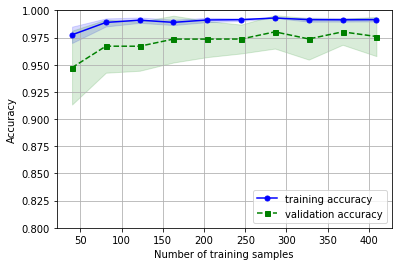

In [51]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.8, 1,0)
plt.show()

### 6.3.2 検証曲線を使って過学習と学習不足を明らかにする

In [52]:
from sklearn.learning_curve import validation_curve

In [53]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [54]:
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='clf__C',
                                            param_range=param_range, cv=10)

In [55]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

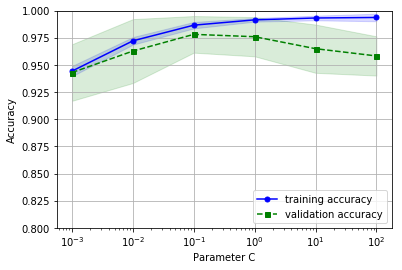

In [57]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.8, 1,0)
plt.show()

## 6.4 グリッドサーチによる機械学習モデルのチューニング

In [58]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

In [60]:
pipe_svc = Pipeline([('scl', StandardScaler()),('clf',SVC(random_state=0))])

In [61]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [62]:
param_grid = [{'clf__C' : param_range, 'clf__kernel': ['linear']},
             {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

In [65]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', 
                 cv=10, n_jobs=-1)

In [66]:
gs = gs.fit(X_train, y_train)

In [67]:
print(gs.best_score_)

0.978021978021978


In [68]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [69]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


### 6.4.2 入れ子式の交差検証によるアルゴリズムの選択

In [71]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                 scoring='accuracy', cv=2, n_jobs=-1)

In [72]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [73]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


## 6.5 さまざまな性能評価指標

* 適合率
* 再現率
* F1スコア

### 6.5.1 混同行列を解釈する

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


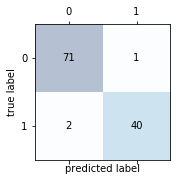

In [83]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### 6.5.2 分類モデルの適合率と再現率を最適化する

誤分類率

$ERR = \frac{FP+FN}{FP+FN+TP+TN}$

正解率

$ACC = 1 - ERR = \frac{TP+TN}{FP+FN+TP+TN}$

In [84]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [85]:
print('Prescision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Prescision: 0.976


In [86]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [87]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [88]:
from sklearn.metrics import make_scorer

In [89]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

### 6.5.3 ROC曲線をプロットする

* ROC: Receiver Operator Charactaristic, 受信者操作特性
* AUC: Area Under the Curve, 曲線下面積

In [90]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [91]:
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)), 
                    ('clf', LogisticRegression(random_state=0,penalty='l2', C=100.0 ))])

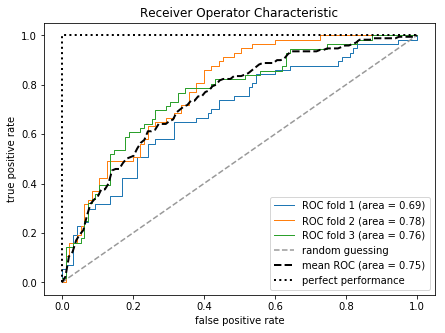

In [100]:
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0,1], [0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':',color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [102]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


In [103]:
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')